# Begin visualisations

 ## todo

 1. Use Pickle or CSV to store values from dataframes so they don't have to be continuously regenerated. 
 1. Improve logistic regression by adding thresholds and finding the correct ones for same author.
 1. Tighten the threshold window down to 1%. 
 1. Run the code against different authors. 
 1. Does the damn thing work?
 1. Are graphs showing actual human behavior?
 1. annotate edges in dataset
 1. regenerate all data
 1. document and lock sequence alignment version
 1. fully remove and document removal of n-grams
 1. display more easy to see
 1. full dataset
 1. moving to dissertation; initial check against tarah's dataset
 1. do full relevant close re-reading

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool, cpu_count





In [2]:
working = Path('..')
working

PosixPath('..')

In [3]:
!pwd

/Users/Jon/Developer/Github/dh-trace/notebooks


In [4]:
!ls $working

LICENSE                   hapaxes_1tM.py            make_histogram.py
Project History.pdf       init_db.py                make_jumbo_dash.py
README.md                 load_alignments.py        make_lines.py
__pycache__               load_authors_and_texts.py notebooks
arch                      load_hapax_intersects.py  poetry.lock
authors.txt               load_hapaxes.py           predict_ops.py
auto_author_prediction.py load_jaccard.py           projects
begin.sh                  load_ngram_intersects.py  pyproject.toml
database_ops.py           load_ngrams.py            requirements.txt
dh-trace-venv             load_relationships.py     show_previous_averages.py
diagrams.ipynb            make_3d_plot.py           util.py
do_svm.py                 make_auto_scatterplot.py  utils
do_viz.sh                 make_confusion.py
explore                   make_dash.py


In [5]:
things = working.glob('*')

In [6]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../__pycache__
../load_hapaxes.py
../Project History.pdf
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../.venv
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [7]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [8]:
project_path

PosixPath('../projects/sm-test')

In [9]:
db_path = project_path / 'db' / f'{project_name}.db'
svm_db_path = project_path / 'db' / 'svm.db'
db_path
svm_db_path

PosixPath('../projects/sm-test/db/svm.db')

In [10]:
db_path.exists()

True

In [11]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num,
        RANDOM() as rand_val
    FROM calculations AS calculation
    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
    JOIN weights AS weight ON weight.weight_id = calculation.weight_id
    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
    JOIN dirs AS dir_a ON dir_a.id = text_a.dir
    JOIN dirs AS dir_b ON dir_b.id = text_b.dir
    JOIN authors AS author_a ON author_a.id = text_a.author_id
    JOIN authors AS author_b ON author_b.id = text_b.author_id
    JOIN combined_jaccard ON combined_jaccard.pair_id = calculation.pair_id
    WHERE weight.weight_id = {weight_id}
      AND calculation.threshold = {threshold}
      AND dir_a.id <> dir_b.id
    ORDER BY rand_val
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""

In [12]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        combined_jaccard.hap_jac_dis,\n        combined_jaccard.hap_jac_sim,\n        combined_jaccard.al_jac_dis,\n        combined_jaccard.al_jac_sim,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        text_a.chapter_num AS a_chap_num,\n        text_b.chapter_num AS b_chap_num,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        text_a.short_name_for_svm AS a_short,\n        text_b.short_name_for_svm AS b_shor

In [13]:
con = sqlite3.connect(db_path)
# Cleanup any edges that might already exist.
con.execute("DROP TABLE IF EXISTS edges")
con.commit()
con.execute("DROP VIEW IF EXISTS edges")
con.commit()


In [14]:
# Create an in-memory database and load the necessary tables
memory_con = sqlite3.connect(':memory:')
with memory_con:
    con.backup(memory_con)

# Fetch unique weight_ids from the database
weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
weight_ids_df = pd.read_sql(weight_ids_query, memory_con)
weight_ids = weight_ids_df['weight_id'].tolist()

# Fetch unique thresholds from the database
thresholds_query = "SELECT DISTINCT threshold FROM calculations"
thresholds_df = pd.read_sql(thresholds_query, memory_con)
thresholds = thresholds_df['threshold'].tolist()

# Create a list of tuples combining weights and thresholds
combinations = [(weight_id, threshold) for weight_id in weight_ids for threshold in thresholds]
print("Weight/Threshold Combos. Can delete: ", combinations)
# Prepare to collect data for the edges DataFrame
edges_data = []

total_iterations = len(weight_ids) * len(thresholds)

with tqdm(total=total_iterations, desc="Processing") as pbar:
    for weight_id, threshold in combinations:
        # Format the query with the current weight_id and threshold
        formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
            
        # Print the formatted query to check for syntax issues
        print(formatted_query)
        
        df = pd.read_sql(formatted_query, memory_con)
        edges_data.append(df)
        
        pbar.update(1)

# Concatenate all the DataFrames into one
edges_df = pd.concat(edges_data, ignore_index=True)

# Display the final DataFrame
print(edges_df)

memory_con.close()
con.close()


Weight/Threshold Combos. Can delete:  [(0, 0.6), (0, 0.65), (0, 0.7), (0, 0.75), (0, 0.8), (0, 0.85), (0, 0.9), (0, 0.95), (1, 0.6), (1, 0.65), (1, 0.7), (1, 0.75), (1, 0.8), (1, 0.85), (1, 0.9), (1, 0.95), (2, 0.6), (2, 0.65), (2, 0.7), (2, 0.75), (2, 0.8), (2, 0.85), (2, 0.9), (2, 0.95), (3, 0.6), (3, 0.65), (3, 0.7), (3, 0.75), (3, 0.8), (3, 0.85), (3, 0.9), (3, 0.95), (4, 0.6), (4, 0.65), (4, 0.7), (4, 0.75), (4, 0.8), (4, 0.85), (4, 0.9), (4, 0.95), (5, 0.6), (5, 0.65), (5, 0.7), (5, 0.75), (5, 0.8), (5, 0.85), (5, 0.9), (5, 0.95), (6, 0.6), (6, 0.65), (6, 0.7), (6, 0.75), (6, 0.8), (6, 0.85), (6, 0.9), (6, 0.95), (7, 0.6), (7, 0.65), (7, 0.7), (7, 0.75), (7, 0.8), (7, 0.85), (7, 0.9), (7, 0.95), (8, 0.6), (8, 0.65), (8, 0.7), (8, 0.75), (8, 0.8), (8, 0.85), (8, 0.9), (8, 0.95), (9, 0.6), (9, 0.65), (9, 0.7), (9, 0.75), (9, 0.8), (9, 0.85), (9, 0.9), (9, 0.95), (10, 0.6), (10, 0.65), (10, 0.7), (10, 0.75), (10, 0.8), (10, 0.85), (10, 0.9), (10, 0.95), (11, 0.6), (11, 0.65), (11, 0

Processing:   0%|          | 0/216 [00:00<?, ?it/s]


WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_

In [ ]:
svm_con = sqlite3.connect(svm_db_path)
memory_con = sqlite3.connect(':memory:')
with memory_con:
    svm_con.backup(memory_con)
memory_con.execute("CREATE INDEX nov_num_idx ON chapter_assessments(novel, number);")

def get_svm_score(a_short, a_chap_num, b_short):
    query = f"""
    SELECT {b_short} AS svm_score
    FROM chapter_assessments
    WHERE novel = ?
    AND number = ?
    """
    
    result = pd.read_sql(query, memory_con, params=(a_short, a_chap_num))
    
    if not result.empty:
        return result['svm_score'].iloc[0]
    return None

# Initialize tqdm to monitor progress
tqdm.pandas(desc="Calculating SVM Scores")

# Apply the function to each row in edges_df
edges_df['svm_score'] = edges_df.progress_apply(lambda row: get_svm_score(row['a_short'], row['a_chap_num'], row['b_short']), axis=1)

# Close the connection to svm.db and memory con
memory_con.close()
svm_con.close()

Calculating SVM Scores:   0%|          | 0/635256 [00:00<?, ?it/s]

In [ ]:
#edges_df = pd.read_sql(df_query, con)
print(f"{len(edges_df):,}")
print(edges_df.sample(n=100, random_state=42))
columns_list = edges_df.columns.tolist()
print(columns_list)
print(len(edges_df))

681,696
        pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
410521     7630       0.781       0.70         16       0.450      0.275   
499317    21001       0.668       0.90         19       0.300      0.300   
110926    13947       0.906       0.75          4       0.175      0.650   
644755    50433       0.948       0.80         25       0.300      0.350   
172065   112787       0.944       0.90          6       0.600      0.200   
...         ...         ...        ...        ...         ...        ...   
445357    11467       0.626       0.85         17       0.275      0.275   
84351    159939       0.772       0.70          3       0.175      0.175   
299638   193921       0.770       0.90         11       0.550      0.225   
225254    74816       0.923       0.95          8       0.200      0.200   
472774   171000       0.917       0.85         18       0.300      0.400   

        svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  ...  a_author_id  \
4

In [ ]:
# NOTE: This is just here so we can see all the columns. Delete when sure it works.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(edges_df)
print(len(edges_df))

,pair_id,comp_score,threshold,weight_id,hap_weight,al_weight,svm_weight,hap_jac_dis,hap_jac_sim,al_jac_dis,al_jac_sim,a_text_id,b_text_id,a_text_filename,b_text_filename,a_chap_num,b_chap_num,a_work_dir_id,b_work_dir_id,a_work,b_work,a_author_id,b_author_id,a_short,b_short,same_author,a_author,b_author,row_num,rand_val,svm_score
0,54,0.516,0.60,0,0.15,0.15,0.7,0.948298,0.051702,0.998171,0.001829,567,135,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_117,1,117,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,1,-4057409300342304398,0.893267
1,60,0.514,0.60,0,0.15,0.15,0.7,0.934469,0.065531,0.997997,0.002003,567,9,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_122,1,122,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,2,-4806000980543970308,0.893267
2,111,0.515,0.60,0,0.15,0.15,0.7,0.944510,0.055490,0.998374,0.001626,567,243,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_169,1,169,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,3,-7341222006911722352,0.893267
3,138,0.516,0.60,0,0.15,0.15,0.7,0.942105,0.057895,0.998650,0.001350,567,240,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_193,1,193,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,4,7128634886570200613,0.893267
4,353,0.662,0.60,0,0.15,0.15,0.7,0.937110,0.062890,0.998567,0.001433,567,629,1840-ENG18400—Trollope-chapter_1,1848-ENG18481—Dickens-chapter_44,1,44,9,10,1840-ENG18400—Trollope,1848-ENG18481—Dickens,9,10,ENG18400—Trollope,ENG18481—Dickens,False Positive,Trollope,Dickens,5,-4019035562808748138,0.668953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635251,211830,0.880,0.95,26,0.35,0.35,0.3,0.948811,0.051189,0.998880,0.001120,350,406,1863-ENG18632—Reade-chapter_55,1880-ENG18800—Disraeli-chapter_30,55,30,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,2937,7729024730348532728,0.668185
635252,212132,0.879,0.95,26,0.35,0.35,0.3,0.950986,0.049014,0.998404,0.001596,327,483,1863-ENG18632—Reade-chapter_7,1880-ENG18800—Disraeli-chapter_21,7,21,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,2938,-3324740497475290824,0.771777
635253,212175,0.880,0.95,26,0.35,0.35,0.3,0.952886,0.047114,0.998606,0.001394,327,457,1863-ENG18632—Reade-chapter_7,1880-ENG18800—Disraeli-chapter_60,7,60,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,2939,-6084038490506919739,0.771777
635254,212207,0.884,0.95,26,0.35,0.35,0.3,0.967287,0.032713,0.997922,0.002078,327,419,1863-ENG18632—Reade-chapter_7,1880-ENG18800—Disraeli-chapter_9,7,9,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,2940,-8899738317096652426,0.771777


635256


In [ ]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 
#check that all four results in same_author are showing up (yes, no, false positive, false negative)

#edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

# Filter the DataFrame for rows where 'same_author' equals 'yes'
print(edges_df[edges_df['same_author'] == 'Yes'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'no'
print(edges_df[edges_df['same_author'] == 'No'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_positive'
print(edges_df[edges_df['same_author'] == 'False Positive'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_negative'
print(edges_df[edges_df['same_author'] == 'False Negative'].head(10))


635256
0.289 0.993
Empty DataFrame
Columns: [pair_id, comp_score, threshold, weight_id, hap_weight, al_weight, svm_weight, hap_jac_dis, hap_jac_sim, al_jac_dis, al_jac_sim, a_text_id, b_text_id, a_text_filename, b_text_filename, a_chap_num, b_chap_num, a_work_dir_id, b_work_dir_id, a_work, b_work, a_author_id, b_author_id, a_short, b_short, same_author, a_author, b_author, row_num, rand_val, svm_score]
Index: []
    pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
0        54       0.516        0.6          0        0.15       0.15   
1        60       0.514        0.6          0        0.15       0.15   
2       111       0.515        0.6          0        0.15       0.15   
3       138       0.516        0.6          0        0.15       0.15   
5       423       0.439        0.6          0        0.15       0.15   
7       878       0.515        0.6          0        0.15       0.15   
8       899       0.588        0.6          0        0.15       0.15   
12      

Now, let's add the logistic regression logic. 

Accuracy: 0.5485
Confusion Matrix:
[[761 681]
 [222 336]]
Classification Report:
                precision    recall  f1-score   support

False Positive       0.77      0.53      0.63      1442
            No       0.33      0.60      0.43       558

      accuracy                           0.55      2000
     macro avg       0.55      0.56      0.53      2000
  weighted avg       0.65      0.55      0.57      2000



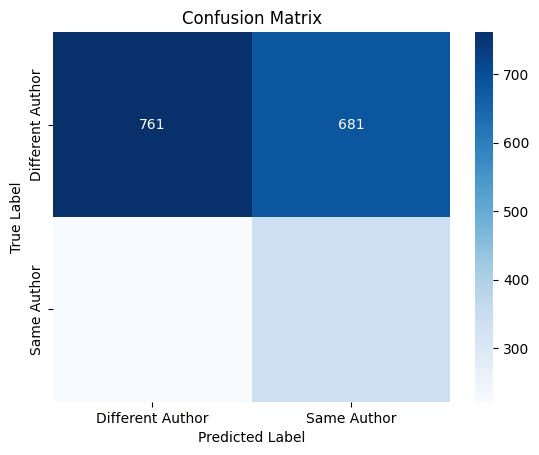

Model coefficients (weights for the features):
hap_jac_sim: 0.22293740296176734
al_jac_sim: -0.10700709072025355
svm_score: -0.030166698452746547


In [ ]:
# Load your data into a DataFrame (assuming it's already done)
# edges_df = pd.read_sql(df_query, con)

# While testing, limit to 10000 edges or this will take forever.
edges_df = edges_df.sample(10000)

# Select relevant features and target
features = ['hap_jac_sim', 'al_jac_sim', 'svm_score']
X = edges_df[features]
y = edges_df['same_author']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model with balanced class weights
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot confusion matrix with labels
labels = ['Different Author', 'Same Author']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Coefficients of the model
print("Model coefficients (weights for the features):")
for feature, coef in zip(features, model.coef_[0]):
    print(f"{feature}: {coef}")

In [ ]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [ ]:
print(edges_df.sample(n=10))

          pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
6508858   1719750       0.526       0.80          8       0.200      0.200   
17100425  1747395       0.727       0.75         22       0.350      0.325   
17929787  5669628       0.857       0.75         23       0.325      0.350   
9692582   3678324       0.982       0.85         12       0.250      0.500   
9495278   3212841       0.761       0.75         12       0.250      0.500   
3137050   5473397       0.830       0.60          4       0.175      0.650   
8225684   1689696       0.844       0.90         10       0.225      0.550   
5313905   4210113       0.791       0.95          6       0.600      0.200   
1558230   2303888       0.913       0.60          2       0.700      0.150   
2890683   2142069       0.431       0.90          3       0.175      0.175   

          svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  al_jac_sim  \
6508858        0.600     0.937863     0.062137    0.999100    0.000

In [ ]:
G

In [ ]:
TEXT_FONT_SIZE = 8

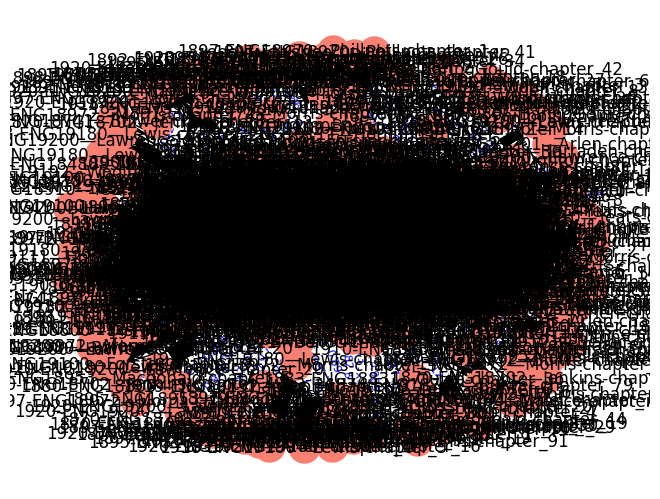

In [ ]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [ ]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [ ]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.297, 0.999, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [ ]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [ ]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS



In [ ]:
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

In [ ]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [ ]:
p4c.create_network_from_networkx(G)


Applying default style...
Applying preferred layout


104356